In [1]:
#Importing Packages
import spacy
import nltk
from nltk import word_tokenize, pos_tag
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
from gensim.corpora import Dictionary
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, HdpModel
#Packages for the visualization
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amit\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## using functions to create bigram ,trigram, adjuctive and noun 

### Data Pre Processing:
### Using Spacy and nltk for preprocessing

In [2]:
#Pre-Processing
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
def Activity_norm(text):
    if text == 'DELIVERY PARTIAL' or text=='BOTH DELIVERY PICK UP PARTIAL' or text=='OTHER SERVICESPartial' or text=='RELOCATION PARTIAL': 
        return('PARTIAL')
    elif text=='DELIVERY CANCELLED RESCHEDULED' or text=='BOTH DELIVERY PICK UP CANCELLED RESCHEDULED' or text == 'RELOCATION CANCELLED RESCHEDULED' or text== 'OTHER SERVICESCancelled Re scheduled':
        return('CANCELLED')
    else:
        return(text)
def remove_stopwords(texts):
    stop_words= stopwords.words("english")
    stop_words.extend(['please','other','reason','unit,','pm','today','tomorrow','plz'])
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigram(texts):
    return [Bigram_mode[doc] for doc in texts]
def make_trigram(texts):
    return [Trigram_mod[doc] for doc in texts]
def Lemmatize(texts,allowed_postags=['NOUN','VERB','ADJ','ADV']):
    text_out=[]
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        text_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return text_out
def compute_coherence_values(id2word, cropus,lemma_data, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=lemma_data, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [3]:
#Data Import'
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    df=pd.read_excel("Feedbaacks_file_1.xlsx")
    df1=pd.read_excel("Feedbaacks_file_2.xlsx", sheet_name='DB')

In [4]:
#Data Merging/..
Comment=pd.concat([df['CRM_Remarks'],df1['CEM Reasons']])
Activity=pd.concat([df['ACTIVITY_STATUS_TYPE'],df1['Activity Type']])
data=pd.DataFrame({"Comment":Comment,"Activity":Activity})
data=data.dropna()

In [5]:
# Data Pre Processing 
# This section is your data specific and 
datax=data
datax['Activity']=datax['Activity'].map(lambda text: " ".join(re.findall('\w+',str(text))))
datax['Activity']=datax['Activity'].map(lambda text: Activity_norm(text))
datax['Activity']=datax['Activity'].map(lambda text: text.lower())
datax=datax[datax['Activity']!=3]
datax=datax[datax['Activity']!='completed']

<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<input>:3: DeprecationWarning: invalid escape sequence \w
<ipython-input-5-38d6e0612dd5>:3: DeprecationWarning: invalid escape sequence \w
  datax['Activity']=datax['Activity'].map(lambda text: " ".join(re.findall('\w+',str(text))))


In [6]:
#Text Pre-Processing
datax['Comment']=datax['Comment'].apply(lambda text: re.sub(r'\(.*\)','',str(text))) #deleting the values inside the bracket
data_words=list(sent_to_words(datax["Comment"])) #using the self made function
Bigram=gensim.models.Phrases(data_words, min_count=5,threshold=100)
Trigram=gensim.models.Phrases(Bigram[data_words],min_count=5,threshold=100)
Bigram_mode=gensim.models.phrases.Phraser(Bigram)
Trigram_mod=gensim.models.phrases.Phraser(Trigram)

In [9]:
#Text pre-processing

#removing the stopwords 
data_words_nonstop=remove_stopwords(data_words)

#making bigrams
bigram_data=make_bigram(data_words_nonstop)

#making trigrams
#rigram_data=make_trigram(bigram_data)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#lemmatization
lemma_data=Lemmatize(bigram_data, allowed_postags=['NOUN','VERB','ADJ','ADV'])

## Count vectorizer

In [25]:
#For testing the frequncy of the different word
cv=CountVectorizer(max_df=0.95, min_df=50, stop_words="english")
x=cv.fit_transform([' '.join(text) for text in lemma_data])
counter=pd.DataFrame(x.todense(),columns=cv.get_feature_names())

In [26]:
#Frequency of the top 100 words
sum_words = x.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
Top_words=words_freq[:100]

In [ ]:
Top_word

## Gensim lda 

In [ ]:
#creating dictionary and corpus
id2word = corpora.Dictionary(lemma_data)
texts=lemma_data
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [29]:
#Fitting the model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=111,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
print(lda_model.print_topics())

[(0, '0.231*"customer" + 0.083*"activity" + 0.070*"schedule" + 0.043*"want" + 0.043*"ask" + 0.041*"reschedule" + 0.034*"cancel" + 0.032*"other" + 0.031*"delivery" + 0.028*"due"'), (1, '0.084*"reach" + 0.078*"champ" + 0.046*"unable" + 0.045*"vehicle" + 0.045*"delay" + 0.037*"come" + 0.034*"time" + 0.034*"washing_machine" + 0.034*"able" + 0.032*"instal"'), (2, '0.151*"warehouse" + 0.131*"ship" + 0.070*"miss" + 0.057*"wardrobe" + 0.055*"chair" + 0.037*"send" + 0.036*"hardware" + 0.035*"stock" + 0.032*"lamp" + 0.024*"door"'), (3, '0.103*"pillow" + 0.067*"early" + 0.061*"possible" + 0.047*"morning" + 0.035*"evening" + 0.029*"fine" + 0.026*"pillow_cover" + 0.025*"slot" + 0.020*"not" + 0.018*"praveen"'), (4, '0.079*"cust" + 0.073*"team" + 0.052*"hence" + 0.044*"transit" + 0.037*"call" + 0.036*"occ" + 0.027*"anand_bhaskar" + 0.027*"pende" + 0.023*"location" + 0.021*"weekend"'), (5, '0.172*"install" + 0.135*"leg" + 0.106*"installation" + 0.069*"product" + 0.038*"thread" + 0.032*"add" + 0.026*"r

In [30]:
#Extraxting only topics from the matrix 
topics=' //Topic\\: '.join([' '.join([''.join(tup[0]) for tup in sent[1]]) for sent in lda_model.show_topics(num_topics=20,formatted =False)])
topics

'customer activity schedule want ask reschedule cancel other delivery due //Topic\\: reach champ unable vehicle delay come time washing_machine able instal //Topic\\: warehouse ship miss wardrobe chair send hardware stock lamp door //Topic\\: pillow early possible morning evening fine pillow_cover slot not praveen //Topic\\: cust team hence transit call occ anand_bhaskar pende location weekend //Topic\\: install leg installation product thread add recliner machine give float_recliner //Topic\\: need deliver bed replace other defect replacement table kindly damage //Topic\\: cx plywood refrigerator phone fit still truck scratch space_constraint case'

## Sklearn lda

#Tried for hours  but  Unable to run the code for lda mallet. First error was the filenotfounderror and the calledProcessError
#mallet_path= "/bin/mallet"
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corp, num_topics=15, id2word=id2word)

In [11]:
skl_texts=[' '.join(text) for text in lemma_data]
no_features = 1000
# NMF(Non negetive Matrix Factorization ) is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(skl_texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(skl_texts)
tf_feature_names = tf_vectorizer.get_feature_names()

In [14]:
no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
#display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

C:\Python36\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
make priority note try mezzo immediately convince state minor kindly
Topic 1:
install unable need service leg fix schedule kindly installation activity
Topic 2:
bed storage door vitello ply refrigerator replacement old frame properly
Topic 3:
seater couch cx order deliver single customer cushion vive want
Topic 4:
bed beam bordo june head_board high refer cusotmer clamp foot_board
Topic 5:
product replace need defect customer replacement table schedule want mismatch
Topic 6:
damage product defect transit nee deliver replacement kindly condition receive
Topic 7:
cux cust needful bedsheet want connect kindly occ pillow pls
Topic 8:
cst speak second wardoebe expect deny sechedule haier_brand function without_fail
Topic 9:
return customer issue sofa refuse space space_constraint truck say cancel
Topic 10:
tv wall_mount recliner machine lead stand problem provide wall_mounting wall
Topic 11:
reach customer delay time home vehicle activity reschedule late dispatch
Topic 12:
unit mai

## sklearn Hdp model

In [15]:
#hdp = HdpModel(corpus=corpus, id2word=id2word)
#[' '.join([''.join(tup[0]) for tup in sent[1]]) for sent in hdp.show_topics(formatted =False)]

C:\Users\Furlenco\Anaconda3\lib\site-packages\gensim\models\hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


['customer product need schedule other deliver bed warehouse want replace table defect replacement ship activity kindly delivery install send damage',
 'customer product schedule deliver bed other activity need want replacement warehouse kindly table defect delivery replace ship chair miss today',
 'customer activity reach reschedule schedule home other ask cancel available today kindly delay want call time pm due request tomorrow',
 'customer product schedule other want replace need replacement bed activity warehouse deliver table kindly defect cancel due seater also ship',
 'customer other product schedule activity want defect need cancel replace kindly replacement ask due reschedule unshipped deliver say today cust',
 'customer product other schedule need deliver activity want replacement defect kindly bed warehouse table ship overtime replace kushal occ delivery',
 'customer product schedule warehouse need other deliver replacement kindly want bed activity reschedule ship delivery 

# visualization

In [15]:
#Visuallization of the results
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.248257  0.163809       1        1  15.577947
5      0.126709 -0.223992       2        1  13.722027
13     0.082395 -0.262703       3        1  11.796009
1      0.143448 -0.100348       4        1   9.643456
16     0.107467 -0.002067       5        1   5.812427
11     0.185145  0.239757       6        1   5.317495
3      0.141881 -0.043776       7        1   5.202392
7      0.084968 -0.043219       8        1   4.828537
6      0.010704 -0.266073       9        1   4.409785
18     0.144213  0.248044      10        1   4.076868
15    -0.085027 -0.116597      11        1   3.135318
9      0.134321  0.119887      12        1   3.027064
19     0.051916 -0.069605      13        1   2.502786
14    -0.145689  0.112702      14        1   2.375598
2     -0.192643 -0.061866      15        1   2.334018
10    -0.179077  0.061662      16        1   2.036513
4     -0.249500  0.009257      17        1   1.277727
0     -0.171928  0.075944      18        1   1.173070
8     -0.225112  0.089039      19        1   1.146205
12    -0.212448  0.070146      20        1   0.604758, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
75    Default  1755.000000            bed  1755.000000  30.0000  30.0000
672   Default  3838.000000        product  3838.000000  29.0000  29.0000
199   Default  6792.000000       customer  6792.000000  28.0000  28.0000
187   Default   726.000000            cst   726.000000  27.0000  27.0000
957   Default   852.000000       wardrobe   852.000000  26.0000  26.0000
863   Default  1315.000000          table  1315.000000  25.0000  25.0000
207   Default   960.000000         damage   960.000000  24.0000  24.0000
788   Default  1283.000000           ship  1283.000000  23.0000  23.0000
213   Default  1633.000000         defect  1633.000000  22.0000  22.0000
960   Default  1454.000000      warehouse  1454.000000  21.0000  21.0000
125   Default   803.000000          chair   803.000000  20.0000  20.0000
693   Default   796.000000          reach   796.000000  19.0000  19.0000
718   Default  1610.000000        replace  1610.000000  18.0000  18.0000
738   Default   592.000000         return   592.000000  17.0000  17.0000
769   Default   673.000000         seater   673.000000  16.0000  16.0000
556   Default  2061.000000           need  2061.000000  15.0000  15.0000
47    Default  1247.000000            ask  1247.000000  14.0000  14.0000
198   Default   615.000000           cust   615.000000  13.0000  13.0000
203   Default   627.000000            cux   627.000000  12.0000  12.0000
414   Default   778.000000        install   778.000000  11.0000  11.0000
528   Default   854.000000           miss   854.000000  10.0000  10.0000
905   Default   500.000000             tv   500.000000   9.0000   9.0000
625   Default   700.000000           pick   700.000000   8.0000   8.0000
727   Default  1299.000000     reschedule  1299.000000   7.0000   7.0000
720   Default  1540.000000    replacement  1540.000000   6.0000   6.0000
22    Default   477.000000          allen   477.000000   5.0000   5.0000
909   Default   832.000000         unable   832.000000   4.0000   4.0000
763   Default  2741.000000       schedule  2741.000000   3.0000   3.0000
176   Default   552.000000          couch   552.000000   2.0000   2.0000
516   Default   396.000000           mili   396.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
618   Topic20     0.090582         permit     5.647403   0.9754  -8.8563
404   Topic20     0.090624        include     5.687625   0.9688  -8.8558
544   Topic20     0.090558  multiple_time     5.773550   0.9530  -8.8566
376   Topic20     0.090579  heavy_traffic     5.790343   0.9504  -8.8563
757   Topic20     0.090583       satin_re     5.807723   0.9474  -8.

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemma_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

NameError: name 'lda_model' is not defined

In [18]:
model_list, coherence_values = compute_coherence_values(id2word, corpus, lemma_data, 40, 2, 6)

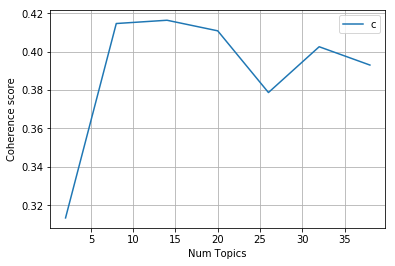

In [19]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()